In [1]:
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd

import xgboost as xgb

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import sklearn

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeClassifier, RANSACRegressor, RANSACRegressor, ARDRegression
from sklearn.tree import  DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import  KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, LinearSVR, SVC, SVR, NuSVC, NuSVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier, BaggingRegressor, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor, BernoulliRBM

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

%precision 3

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Input, BatchNormalization

In [3]:
df = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')
submission = pd.read_csv('input/gender_submission.csv')

In [4]:
print(df.shape, df_test.shape)

(891, 12) (418, 11)


In [5]:
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [6]:
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [7]:
print(df_test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [8]:
print(df.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


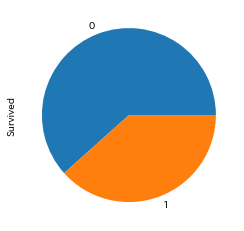

In [9]:
df['Survived'].value_counts().plot.pie()

3    491
1    216
2    184
Name: Pclass, dtype: int64


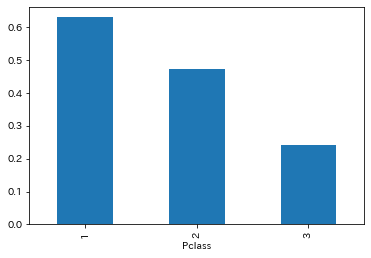

In [10]:
print(df['Pclass'].value_counts())
df.groupby('Pclass')['Survived'].mean().plot.bar()

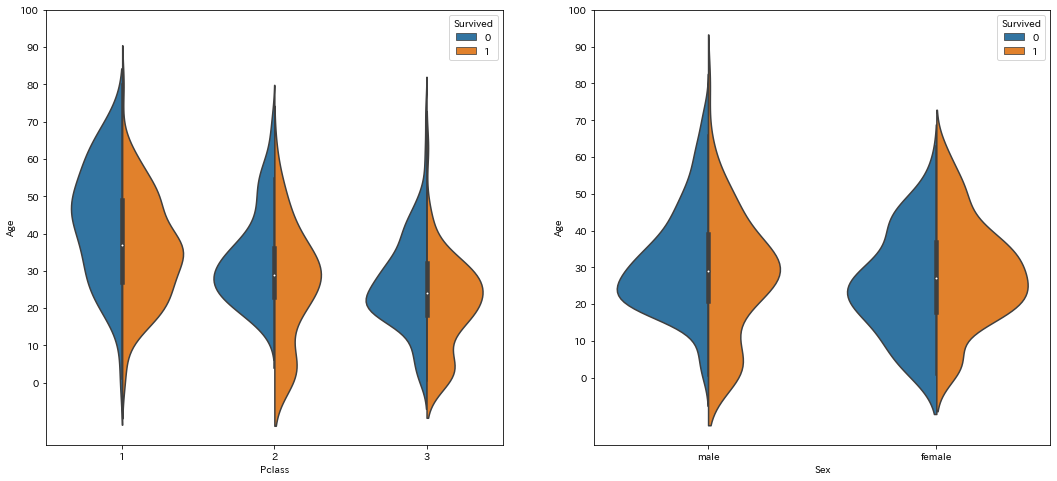

In [11]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.violinplot('Pclass', 'Age', hue='Survived', data=df, split=True, ax=ax[0])
ax[0].set_yticks(range(0, 110, 10))

sns.violinplot('Sex', 'Age', hue='Survived', data=df, split=True, ax=ax[1])
ax[1].set_yticks(range(0, 110, 10))

In [12]:
df.groupby('Sex')['Age'].describe()

count       mean        std   min   25%   50%   75%   max
Sex                                                              
female  261.0  27.915709  14.110146  0.75  18.0  27.0  37.0  63.0
male    453.0  30.726645  14.678201  0.42  21.0  29.0  39.0  80.0

In [13]:
df['Age'].fillna(df['Age'].mean(), inplace=True)
df_test['Age'].fillna(df_test['Age'].mean(), inplace=True)

df_test['Fare'].fillna(df_test['Fare'].mean(), inplace=True)

In [14]:
df.drop('Cabin', axis=1, inplace=True)
df_test.drop('Cabin', axis=1, inplace=True)

In [15]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [16]:
df['Embarked'].fillna('S', inplace=True)

In [17]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [18]:
df_test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [19]:
df.drop('Name', axis=1, inplace=True)
df_test.drop('Name', axis=1, inplace=True)

df.drop('Ticket', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)

df.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)
df_test.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)

df.head()

PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare Embarked
0            1         0       3    0  22.0      1      0   7.2500        S
1            2         1       1    1  38.0      1      0  71.2833        C
2            3         1       3    1  26.0      0      0   7.9250        S
3            4         1       1    1  35.0      1      0  53.1000        S
4            5         0       3    0  35.0      0      0   8.0500        S

In [20]:
df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

In [21]:
print(df.shape, df_test.shape)

(891, 11) (418, 10)


In [22]:
y = df['Survived']
X = df.drop('Survived', axis=1)

In [23]:
X.shape

(891, 10)

In [24]:
y = y.values
X = X.values

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

In [26]:
X_train.dtype, X_train.shape

(dtype('float64'), (623, 10))

In [27]:
X_train = np.array(X_train, np.float32)
X_valid = np.array(X_valid, np.float32)
y_train = np.array(y_train, np.int32)
y_valid = np.array(y_valid, np.int32)

In [28]:
import os, random

def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [29]:
reset_seed(0)

model = Sequential()
model.add(BatchNormalization(input_shape=(10, )))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 10)                40        
_________________________________________________________________
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 172
Trainable params: 152
Non-trainable params: 20
_________________________________________________________________


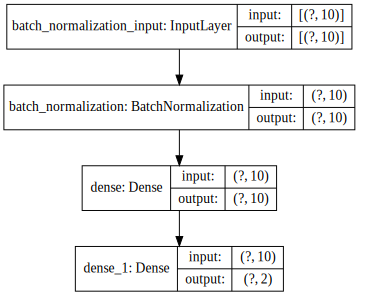

In [30]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [31]:
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=100,
                    validation_data=(X_valid, y_valid))

Train on 623 samples, validate on 268 samples
Epoch 1/100
623/623 [==============================] - 3s 5ms/sample - loss: 0.9259 - accuracy: 0.4446 - val_loss: 1.6513 - val_accuracy: 0.3545
Epoch 2/100
623/623 [==============================] - 0s 517us/sample - loss: 0.6586 - accuracy: 0.6164 - val_loss: 0.7561 - val_accuracy: 0.5410
Epoch 3/100
623/623 [==============================] - 0s 507us/sample - loss: 0.5623 - accuracy: 0.7095 - val_loss: 0.5636 - val_accuracy: 0.6978
Epoch 4/100
623/623 [==============================] - 0s 527us/sample - loss: 0.5412 - accuracy: 0.7464 - val_loss: 0.5013 - val_accuracy: 0.7687
Epoch 5/100
623/623 [==============================] - 0s 717us/sample - loss: 0.5024 - accuracy: 0.7881 - val_loss: 0.4763 - val_accuracy: 0.7761
Epoch 6/100
623/623 [==============================] - 1s 1ms/sample - loss: 0.4963 - accuracy: 0.7737 - val_loss: 0.4648 - val_accuracy: 0.7985
Epoch 7/100
623/623 [==============================] - 0s 683us/sample - los

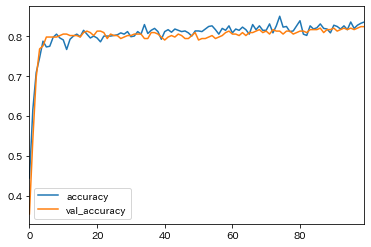

In [32]:
result = pd.DataFrame(history.history)
result[['accuracy', 'val_accuracy']].plot()

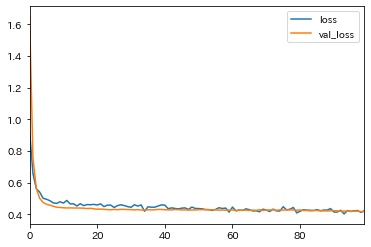

In [33]:
result[['loss', 'val_loss']].plot()

In [34]:
# 推定

X_test = df_test.values

y_pred = pd.DataFrame(model.predict(X_test))
y_pred

0         1
0    0.944999  0.055001
1    0.815936  0.184064
2    0.963843  0.036157
3    0.910691  0.089309
4    0.750243  0.249757
..        ...       ...
413  0.888755  0.111246
414  0.027519  0.972480
415  0.887052  0.112948
416  0.888575  0.111425
417  0.541371  0.458629

[418 rows x 2 columns]

In [36]:
sub_df = y_pred[0]

for i in range(len(y_pred)):
    if y_pred[0][i] > y_pred[1][i]:
        sub_df[i] = 0
    else:
        sub_df[i] = 1

sub_df

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
413    0.0
414    1.0
415    0.0
416    0.0
417    0.0
Name: 0, Length: 418, dtype: float32

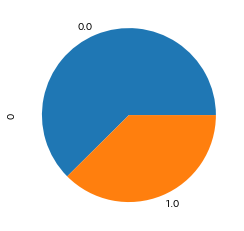

In [37]:
sub_df.value_counts().plot.pie()

In [39]:
# 提出

submission['Survived'] = sub_df
submission = submission.astype('int64')

submission.to_csv('input/your_submssion.csv', index=False)